# Vowel Task
1. In the first part a single Gaussian class model with respectively a full and a diagonal covariance matrix is to be analyzed.

(a) Find the sample mean and the sample covariance matrix for each class set.

(b) Design a classifier assuming full covariance pdfs and find the confusion matrix and the error rate for the test set.

(c) Repeat the above for diagonal covariance matrixes (i.e. set off-diagonal matrix values to zero). Compare the confusion matrixes and the error rates.

col1:  filename
col2:  duration in msec
col3:  f0 at "steady state"
col4:  F1 at "steady state"
col5:  F2 at "steady state"
col6:  F3 at "steady state"
col7:  F4 at "steady state"
col8:  F1 at 20% of vowel duration
col9:  F2 at 20% of vowel duration
col10: F3 at 20% of vowel duration
col11: F1 at 50% of vowel duration
col12: F2 at 50% of vowel duration
col13: F3 at 50% of vowel duration
col14: F1 at 80% of vowel duration
col15: F2 at 80% of vowel duration
col16: F3 at 80% of vowel duration

In [35]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture as GMM

vowels = ['ae', 'ah', 'aw', 'eh', 'er', 'ei', 'ih', 'iy', 'oa', 'oo', 'uh', 'uw']

def GetData():
    data=np.genfromtxt('vowdata_nohead.dat',dtype='U16')
    rowheader=data[:,0]
    data=data[:,3:6].astype(int) #formants at "steady state", can probably vary this to get a better error rate
    return data, rowheader

def sort_data(rowheader,data):

    train, test=[],[]
    for vowel in vowels:
        header=np.flatnonzero(np.core.defchararray.find(rowheader, vowel)!=-1)
        #train.extend(header[:70]) #the task says the 70 first samples of all the classes
        #test.extend(header[70:])  #assuming this means exactly that, so no mix of speakers, the 70 first are male or female
        
        train.extend(header[0::2]) #a mix of all speakers in the training and test sets
        test.extend(header[1::2])  #gives a lower error rate
    return data[train], rowheader[train], data[test], rowheader[test]

def mean_covariance(data,rowheader):
    
    for i, vowel in enumerate(vowels):
        x=np.flatnonzero(np.core.defchararray.find(rowheader,vowel)!=-1)
        classes=data[x]
        sam_mean=classes.mean(axis=0)
        z = classes - sam_mean
        cov_mat=np.dot(z,z.T)/(len(classes)-1)
    return sam_mean, cov_mat #the values should be filled into an array to be able to see all values at the same time

def singleGaussianModel(d_train, rh_train, d_test, rh_test, diagonal):
    
    training = np.empty((12, d_train.shape[0]))
    testing = np.empty((12, d_test.shape[0]))
    
    for i, vowel in enumerate(vowels):
        x=np.flatnonzero(np.core.defchararray.find(rh_train,vowel)!=-1)
        classes=d_train[x]
        sam_mean=classes.mean(axis=0)
        
        z = classes - sam_mean
        cov_mat=np.dot(z.T,z)/(len(classes)-1) #unbiased covariance
            
        if diagonal:
            cov_mat=np.diag(np.diag(cov_mat))
            
        rv=multivariate_normal(mean=sam_mean, cov=cov_mat)
            
        training[i] = rv.pdf(d_train)
        testing[i] = rv.pdf(d_test)
        
    training_pred=np.argmax(training, axis=0)
    testing_pred=np.argmax(testing, axis=0)
    
    training_actual=np.asarray([i for i in range(12) for _ in range(70)])
    testing_actual=np.asarray([i for i in range(12) for _ in range(69)])
        
    return  training_pred, testing_pred, training_actual, testing_actual
    
def plot_conf(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Gotten from the 'scikit learn', as it would not import.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.subplots(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    # solving a plot cutoff bug
    plt.ylim(len(cm)-0.5, -0.5)
    plt.show()

In [36]:
def Part1():
    print('PART 1')
    data,rowheader=GetData()
    d_train, rh_train, d_test, rh_test = sort_data(rowheader,data) #training set is only male or female. 
    
    #a, takes the entire sample set of the classes
    print('A')
    sample_mean, cov_mat=mean_covariance(data,rowheader) 
    print('sample mean:', sample_mean, 'Covariance matrix', cov_mat) #a
    
    #b, full covariance
    print('B')
    train_predb, test_predb, train_actb, test_actb=singleGaussianModel(d_train, rh_train, d_test, rh_test, diagonal=False)
    cm=confusion_matrix(test_actb,test_predb)
    plot_conf(cm,vowels)
    error=1-np.sum(test_predb==test_actb)/len(test_predb)
    print('Error rate:',error*100,'%')
    #print(test_actb, test_predb)

    
    #c, diagonal covariance
    print('C')
    train_predc, test_predc, train_actc, test_actc=singleGaussianModel(d_train, rh_train, d_test, rh_test, diagonal=True)
    cm=confusion_matrix(test_actc,test_predc)
    plot_conf(cm,vowels)
    error=1-np.sum(test_predc==test_actc)/len(test_predc)
    print('Error rate:',error*100,'%')

 

2. In the second part you shall use a mixture of 2-3 Gaussians for each class. The Matlab function GMMi = fitgmdist(trainvi,M); will put M mixtures into GMMi using the training vectors trainvi from class !i. The function mvnpdf will calculate the likelihoods for a test set. Another option is to use a class of function gmmdistribution.fit to do the training and the function pdf in the test phase
(a) Find GMM models with diagonal covariance matrixes for both 2 and 3 mixtures for each class.
(b) Modify the classifier in task 1b to deal with mixture of gaussians
(c) Find the confusion matrixes and the error rates for the GMM classifier using respectively M = 2 and M = 3 Gaussians pr class.
(d) Compare the performances for all four model types (tasks 1b, 1c and 2c). For which classe(s) is the difference largest?

In [48]:
def GaussianMixtureModel(d_train, rh_train, d_test, rh_test, M):
    
    training = np.empty((12, d_train.shape[0]))
    testing = np.empty((12, d_test.shape[0]))
    
    for i, vowel in enumerate(vowels):
        x=np.flatnonzero(np.core.defchararray.find(rh_train,vowel)!=-1)
        classes=d_train[x]

        gmm=GMM(n_components=M,covariance_type='diag', random_state=0)    
        gmm.fit(classes,rh_train[x])
        
        for j in range(M):
            rv=multivariate_normal(mean=gmm.means_[j], cov=gmm.covariances_[j], allow_singular=True)    
            training[j] = gmm.weights_[j]*rv.pdf(d_train)
            testing[j] = gmm.weights_[j]*rv.pdf(d_test)
        
        
    training_pred=np.argmax(training, axis=0)
    testing_pred=np.argmax(testing, axis=0)
    
    training_actual=np.asarray([i for i in range(12) for _ in range(70)])
    testing_actual=np.asarray([i for i in range(12) for _ in range(69)])
        
    return  training_pred, testing_pred, training_actual, testing_actual    

In [49]:
def Part2():
    print('PART 2')
    data,rowheader=GetData()
    d_train, rh_train, d_test, rh_test = sort_data(rowheader,data)
    
    print('M=2')
    train_pred2, test_pred2, train_act2, test_act2=GaussianMixtureModel(d_train, rh_train, d_test, rh_test, 2)
    cm=confusion_matrix(test_act2,test_pred2)
    plot_conf(cm,vowels)
    error=1-np.sum(test_pred2==test_act2)/len(test_pred2)
    print('Error rate:',error*100,'%')
    
    print('M=3')
    train_pred3, test_pred3, train_act3, test_act3=GaussianMixtureModel(d_train, rh_train, d_test, rh_test, 3)
    cm=confusion_matrix(test_act3,test_pred3)
    plot_conf(cm,vowels)
    error=1-np.sum(test_pred3==test_act3)/len(test_pred3)
    print('Error rate:',error*100,'%')

PART 1
A
sample mean: [ 444.69064748 1157.50359712 2675.79136691] Covariance matrix [[  835.13547098  1453.52031093   679.52396019 ... -1004.76036887
  -2065.74889979 -1660.65057844]
 [ 1453.52031093  2941.7457306   1126.16966971 ... -1986.17263037
  -3582.09594389 -3112.25124573]
 [  679.52396019  1126.16966971   566.40520302 ...  -777.82115502
  -1657.31693232 -1291.42150952]
 ...
 [-1004.76036887 -1986.17263037  -777.82115502 ...  1354.57567534
   2509.21757921  2162.39561069]
 [-2065.74889979 -3582.09594389 -1657.31693232 ...  2509.21757921
   5221.92470046  4230.01577543]
 [-1660.65057844 -3112.25124573 -1291.42150952 ...  2162.39561069
   4230.01577543  3571.70829967]]
B


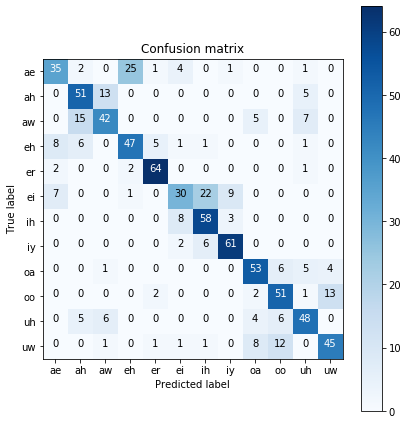

Error rate: 29.34782608695652 %
C


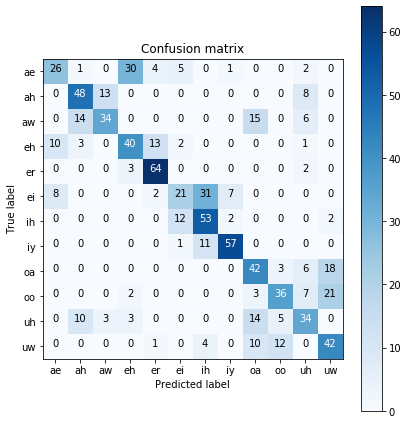

Error rate: 39.97584541062802 %
PART 2
M=2


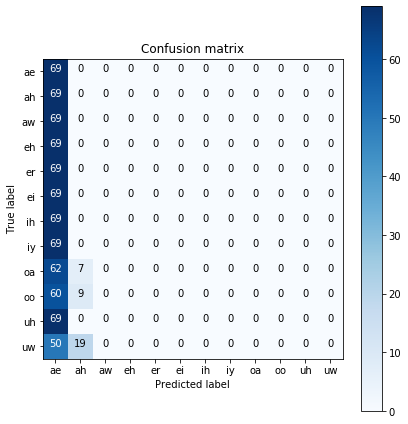

Error rate: 91.66666666666666 %
M=3


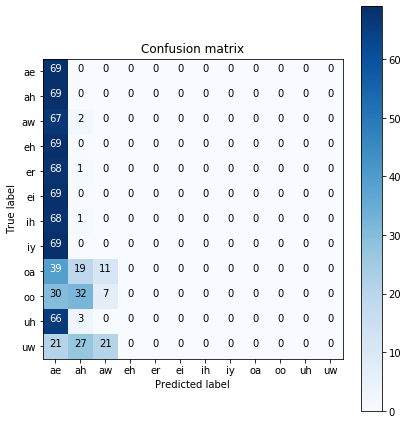

Error rate: 91.66666666666666 %


In [50]:
if __name__ == '__main__':
    Part1()
    Part2()